# Pairs selection

In developing a Pairs Trading strategy, finding valid, eligible pairs which exhibit unconditional mean-reverting behavior is of utmost importance. We use K-Means clustering to help navigate a very high-dimensional search space to find tradeable pairs.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd

from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn import metrics

from statsmodels.tsa.stattools import coint

from scipy import stats

from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters.morningstar import Q500US, Q1500US, Q3000US
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

In [3]:
end_date = "2016-12-31"

## Define Universe
We start by specifying that we will constrain our search for pairs to the a large and liquid single stock universe.

In [4]:
universe = Q1500US()

## Choose Data
In addition to pricing, we use some fundamental and industry classification data. When we look for pairs (or model anything in quantitative finance), it is generally good to have an economic prior, as this helps mitigate the effect of overfitting.

A few economic priors to consider:

- Stocks that share loadings to common factors (defined below) in the past should be related in the future.

- Stocks of similar market caps should be related in the future.

- We should exclude stocks in the industry group "Conglomerates" (industry code 31055). Morningstar analysts classify stocks into industry groups primarily based on similarity in revenue lines. "Conglomerates" is a catch-all industry. As described in the [Morningstar Global Equity
Classification Structure manual](http://corporate.morningstar.com/us/documents/methodologydocuments/methodologypapers/equityclassmethodology.pdf): "If the company has more than three sources of revenue and
income and there is no clear dominant revenue and income stream, the company
is assigned to the Conglomerates industry." 

- Creditworthiness in an important feature in future company performance. Instead of using accounting-based ratios to formulate a measure to reflect the financial health of a firm, we use structural or contingent claim models. Structural models take advantage of both market information and accounting financial information. Therefore, we use a contingent claims approach to modeling the capital structure of the firm. The output is an implied probability of default. Morningstar analysts calculate this for us and the field is called `financial_health_grade`. We rank the calculated distance to default and award 10% of the universe A's, 20% B's, 40% C's, 20% D's, and 10% F's. 

In [5]:
pipe = Pipeline(
    columns= {
        'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
        'Industry': morningstar.asset_classification.morningstar_industry_group_code.latest,
        'Financial Health': morningstar.asset_classification.financial_health_grade.latest
    },
    screen=universe
)

In [6]:
res = run_pipeline(pipe, end_date, end_date)
res.index = res.index.droplevel(0)  # drop the single date from the multi-index

In [7]:
print res.shape
res.head()

(1500, 3)


,Financial Health,Industry,Market Cap
Equity(2 [ARNC]),C,10106,4
Equity(24 [AAPL]),A,31167,4
Equity(53 [ABMD]),A,20639,3
Equity(62 [ABT]),B,20639,4
Equity(67 [ADSK]),B,31165,4


In [8]:
# remove stocks in Industry "Conglomerates"
res = res[res['Industry']!=31055]
print res.shape

(1499, 3)


In [9]:
# remove stocks without a Financial Health grade
res = res[res['Financial Health']!= None]
print res.shape

(1498, 3)


In [10]:
# replace the categorical data with numerical scores per the docs
res['Financial Health'] = res['Financial Health'].astype('object')
health_dict = {u'A': 0.1,
               u'B': 0.3,
               u'C': 0.7,
               u'D': 0.9,
               u'F': 1.0}
res = res.replace({'Financial Health': health_dict})

In [11]:
res.describe()

,Financial Health,Industry,Market Cap
count,1498.000000,1498.000000,1498.000000
mean,0.447397,20268.038051,3.389853
std,0.266994,9214.022203,0.647861
min,0.100000,10101.000000,2.000000
25%,0.300000,10320.000000,3.000000
50%,0.300000,20635.000000,3.000000
75%,0.700000,31054.000000,4.000000
max,1.000000,31169.000000,4.000000


## Define Horizon
We are going to work with a daily return horizon in this strategy.

In [12]:
#pricing = get_pricing(
    #symbols=res.index,
    #fields='close_price',
    #start_date=pd.Timestamp(end_date) - pd.DateOffset(months=12),
    #end_date=pd.Timestamp(end_date)
#)
pricing = get_pricing(
    symbols=res.index,
    fields='open_price',
    start_date=pd.Timestamp(end_date) - pd.DateOffset(months=12),
    end_date=pd.Timestamp(end_date)
)

In [13]:
pricing.shape
#pricing[2]

(253, 1498)

In [14]:
returns = pricing.pct_change()

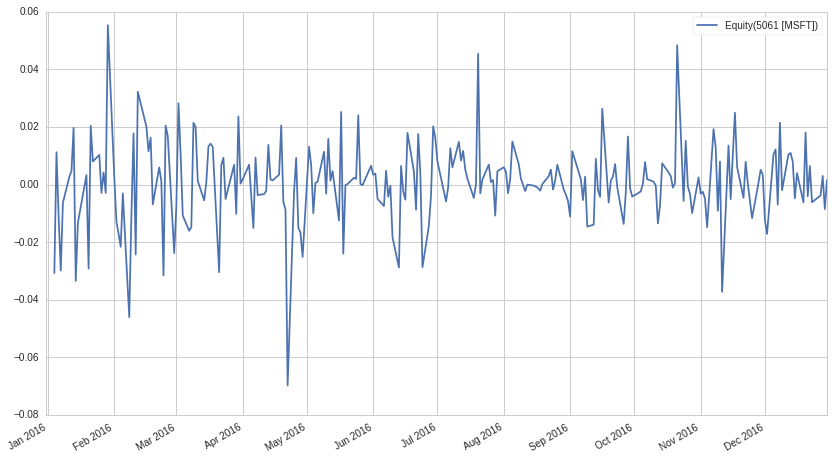

In [15]:
returns[symbols(['MSFT'])].plot();

In [16]:
# We can only work with stocks that have the full return series
returns = returns.iloc[1:,:].dropna(axis=1)

In [17]:
print returns.shape

(252, 1462)


## Find Candidate Pairs

Given the pricing data and the fundamental and industry/sector data, we will first classify stocks into clusters and then, within clusters, looks for strong mean-reverting pair relationships.

### PCA

- The first hypothesis above is that "Stocks that share loadings to common factors in the past should be related in the future". Common factors are things like sector/industry membership and widely known ranking schemes like momentum and value. We could specify the common factors *a priori* to well known factors. In this post we let the data speak for itself. We use PCA to reduce the dimensionality of the returns data and extract the historical latent common factor loadings for each stock. 

### K-Means

- We will take these features, add in the fundamental features, and then use the `K-means` algorithm. K-means is a simple unsupervised machine learning algorithm that groups a dataset into a user-specified number (k) of clusters. The algorithm is somewhat naive--it clusters the data into k clusters, even if k is not the right number of clusters to use. Therefore, when using k-means clustering, users need some way to determine whether they are using the right number of clusters.

### Elbow method

- One method to validate the number of clusters is the elbow method. The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k, and for each value of k calculate the sum of squared errors (SSE). 
- Then, to visualize the result, plot a line chart of the SSE for each value of k. If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best. The idea is that we want a small SSE, but that the SSE tends to decrease toward 0 as we increase k (the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster). So our goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.



At the end, the clustering algorithm will give us sensible *candidate* pairs. We will perform a statistical test
called cointegration test to check if these candidate pairs can be used for pairs trading


### PCA Decomposition and K-means Clustering

In [18]:
N_PRIN_COMPONENTS = 30 # 40, 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(returns)

PCA(copy=True, n_components=30, whiten=False)

In [19]:
pca.components_.T.shape

(1462, 30)

We have reduced data now with the first `N_PRIN_COMPONENTS` principal component loadings. Let's add some fundamental values as well to make the model more robust.

In [20]:
X = np.hstack(
    (pca.components_.T,
     res['Market Cap'][returns.columns].values[:, np.newaxis],
     res['Financial Health'][returns.columns].values[:, np.newaxis])
)
print X.shape

(1462, 32)


In [21]:
# Standardize features by removing the mean and scaling to unit variance
X = preprocessing.StandardScaler().fit_transform(X)
print X.shape

(1462, 32)


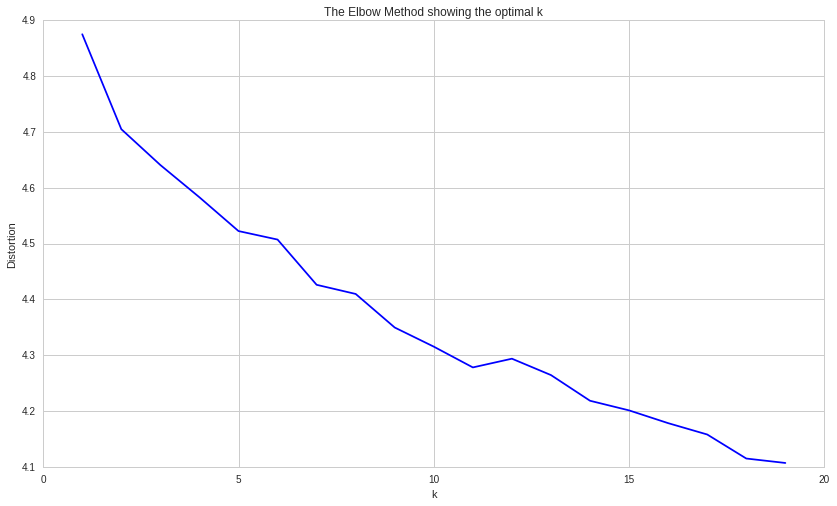

In [22]:
## Elbow method with k-means clustering

import random
random.seed(123)

distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [23]:
# K-means algorithm
clf = KMeans(n_clusters=12)
print clf

clf.fit(X)

labels = clf.labels_
clustered = clf.labels_

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=12, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


In [24]:
# The initial dimensionality of the search was
ticker_count = len(returns.columns)
print "Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2)

Total pairs possible in universe: 1067991 


In [25]:
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

clustered_series.head()

Equity(2 [ARNC])     8
Equity(24 [AAPL])    4
Equity(53 [ABMD])    3
Equity(62 [ABT])     4
Equity(67 [ADSK])    4
dtype: int32

In [26]:
CLUSTER_SIZE_LIMIT = 100
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print "Clusters formed: %d" % len(ticker_count_reduced)
print "Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum()

Clusters formed: 5
Pairs to evaluate: 12084



### Cluster Visualization
As an attempt to visualize what has happened in 2d, we can try with [T-SNE]. T-SNE is an algorithm for visualizing very high dimension data in 2d. We visualize the discovered pairs to help us gain confidence that the `K-Means` output is sensible; i.e., we want to see that T-SNE and K-Means both find our clusters.

In [27]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

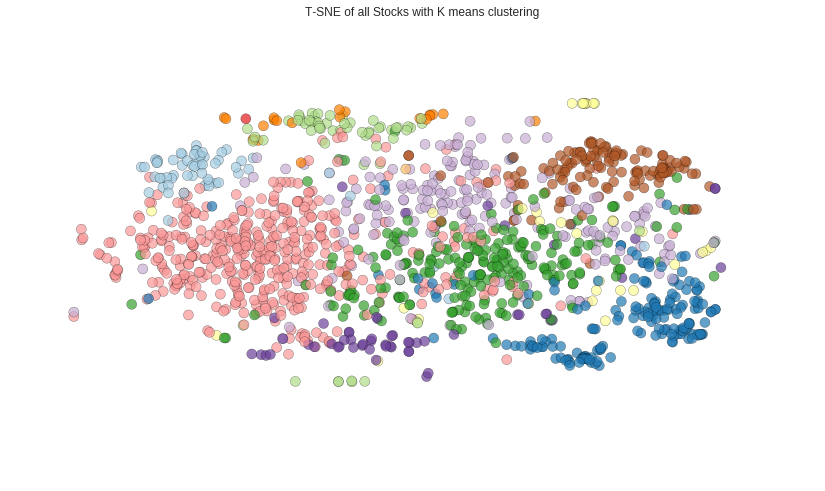

In [28]:
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.7,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with K means clustering');

We can also see how many stocks we found in each cluster and then visualize the normalized time series of the members of a handful of the smaller clusters.

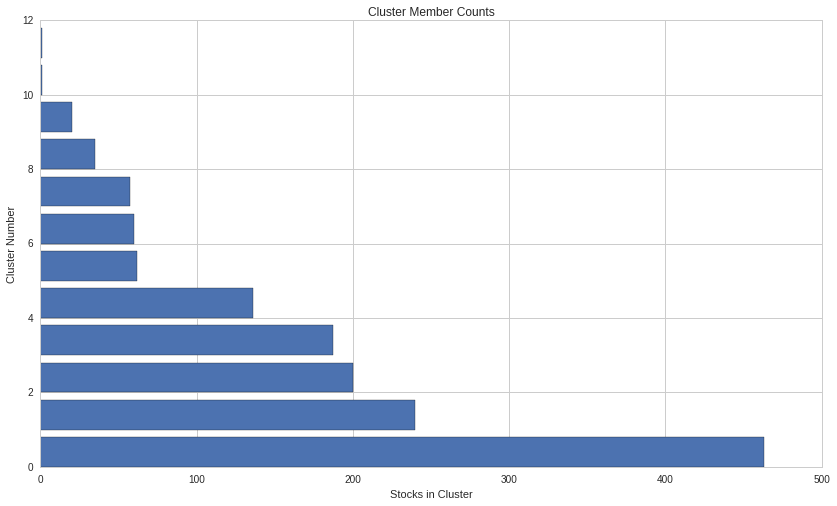

In [29]:
plt.barh(
    xrange(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

To again visualize if our clustering is doing anything sensible, let's look at a few clusters.

In [30]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# Plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(pricing[tickers].mean())
    data = np.log(pricing[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)

In [ ]:
#which_cluster = clustered_series.loc[symbols('JPM')]
#clustered_series[clustered_series == which_cluster]

In [ ]:
#tickers = list(clustered_series[clustered_series==which_cluster].index)
#means = np.log(pricing[tickers].mean())
#data = np.log(pricing[tickers]).sub(means)
#data.plot(legend=False, title="Stock Time Series for Cluster %d" % which_cluster);

Now that we have sensible clusters of common stocks, we can run a statistical test to find cointegrated pairs.

In [31]:
def find_cointegrated_pairs(data, significance=0.01):
    '''Function that tests for co-integration among all pairs of data set'''
     # From https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [32]:
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        pricing[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [33]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [34]:
pairs

[(Equity(739 [BBBY]), Equity(2126 [DDS])),
 (Equity(2126 [DDS]), Equity(8816 [FOSL])),
 (Equity(2845 [FINL]), Equity(11086 [AEO])),
 (Equity(7061 [SPLS]), Equity(21090 [TGT])),
 (Equity(7233 [SVU]), Equity(7949 [VFC])),
 (Equity(7233 [SVU]), Equity(8284 [WSM])),
 (Equity(7233 [SVU]), Equity(8816 [FOSL])),
 (Equity(7233 [SVU]), Equity(9909 [DECK])),
 (Equity(7233 [SVU]), Equity(10303 [URBN])),
 (Equity(7233 [SVU]), Equity(10513 [SHOO])),
 (Equity(7233 [SVU]), Equity(15622 [ANF])),
 (Equity(7233 [SVU]), Equity(18403 [COLM])),
 (Equity(7233 [SVU]), Equity(21090 [TGT])),
 (Equity(7233 [SVU]), Equity(22099 [TPR])),
 (Equity(7233 [SVU]), Equity(23438 [GME])),
 (Equity(7233 [SVU]), Equity(25576 [CRI])),
 (Equity(7233 [SVU]), Equity(27409 [DSW])),
 (Equity(7233 [SVU]), Equity(34395 [LULU])),
 (Equity(7233 [SVU]), Equity(39626 [EXPR])),
 (Equity(7233 [SVU]), Equity(42270 [KORS])),
 (Equity(7233 [SVU]), Equity(43201 [FIVE])),
 (Equity(7233 [SVU]), Equity(45199 [SFM])),
 (Equity(7233 [SVU]), Equi

In [ ]:
print "We found %d pairs." % len(pairs)

In [ ]:
print "In those pairs, there are %d unique tickers." % len(np.unique(pairs))

**Acknowledgement:**

This post borrows heavily from Jonathan Larkin's [notebook](https://www.quantopian.com/posts/pairs-trading-with-machine-learning) on  pair selection. 